## Step 1: Defining the Hamiltonian

The Hamiltonian for a 2-level atom coupled to an N-level cavity (Jaynes-Cummings model) is:

\begin{equation}
H = \sum_i -\frac{\hbar \omega_i}{2} \sigma_{z,i} + \hbar \omega a^\dagger a +  \sum_i \hbar g_i ( a  \sigma_{+,i} + a^\dagger \sigma_{-,i} )
\end{equation}

We will represent the Hamiltonian in the uncoupled basis, diagonalize it, and find the polariton states.

### Uncoupled basis
If we truncate the photonic states at $|1\rangle$, we can represent the uncoupled basis as
$$ |0\rangle \otimes |g\rangle \otimes |g\rangle, \; |0\rangle \otimes |e\rangle \otimes |g\rangle,  \; |0\rangle \otimes |g\rangle \otimes |e\rangle,  \; |0\rangle \otimes |e\rangle \otimes |e\rangle, \; |1\rangle \otimes |g\rangle \otimes |g\rangle ...$$

We will represent the Hamiltonian in the uncoupled basis and diagonalize it to obtain the polariton states.  We can construct these uncoupled basis states here.

In [1]:
import numpy as np
import scipy.linalg as la

# Define the cavity states
z_ket = np.array([[1], [0]])  # |0> as a column vector
o_ket = np.array([[0], [1]])  # |1> as a column vector
g_ket = np.array([[1], [0]])  # |g> as a column vector (ground state of the atom)
e_ket = np.array([[0], [1]])  # |e> as a column vector (excited state of the atom)

# Define the tensor products (composite states)
zgg_ket = np.kron(z_ket, np.kron(g_ket, g_ket))  # |0> ⊗ |g> ⊗ |g>
zge_ket = np.kron(z_ket, np.kron(g_ket, e_ket))  # |0> ⊗ |g> ⊗ |e>
zeg_ket = np.kron(z_ket, np.kron(e_ket, g_ket))  # |0> ⊗ |e> ⊗ |g>
zee_ket = np.kron(z_ket, np.kron(e_ket, e_ket))  # |0> ⊗ |e> ⊗ |e>
ogg_ket = np.kron(o_ket, np.kron(g_ket, g_ket))  # |1> ⊗ |g> ⊗ |g>
oge_ket = np.kron(o_ket, np.kron(g_ket, e_ket))  # |1> ⊗ |g> ⊗ |e>
oeg_ket = np.kron(o_ket, np.kron(e_ket, g_ket))  # |1> ⊗ |e> ⊗ |g>
oee_ket = np.kron(o_ket, np.kron(e_ket, e_ket))  # |1> ⊗ |e> ⊗ |e>

In [8]:
# Function to compute the expectation value of the Hamiltonian for a given state
def compute_expectation_value(state, H):
    return np.vdot(state, H @ state)

def print_operator_action(op, ket, op_name="Operator", ket_name="Ket"):
    """ prints the action of an operator on a ket in a formatted way """
    result = op @ ket

    # Formatters
    fmt = {'all': lambda x: f"{x: 6.3f}"}

    print(f"\n=== {op_name} acting on {ket_name} ===\n")

    print(f"{op_name} matrix in tensor product space:")
    print(np.array2string(op, formatter=fmt))

    print(f"\n{ket_name} vector in tensor product space:")
    print(np.array2string(ket.reshape(-1, 1), formatter=fmt))

    print(f"\nResulting vector in tensor product space ({op_name} ⋅ {ket_name}):")
    print(np.array2string(result.reshape(-1, 1), formatter=fmt))

def represent_basis_in_eigen(basis_names, eigvecs, energies=None, tol=1e-6):
    """
    For each original basis state |b_j>, prints its expansion
      |b_j> = sum_i c_{j,i} |ψ_i>
    where c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j, i]) for a unitary eigvecs.
    
    Parameters
    ----------
    basis_names : list of str
        Names of the basis kets in the same order as the rows of eigvecs.
    eigvecs : np.ndarray, shape (N, N)
        Columns are the eigenvectors |ψ_i> expressed in the original basis.
    energies : array-like, optional
        If provided, labels the eigenstates by energy order.
    tol : float
        Threshold below which coefficients are treated as zero.
    """
    N = eigvecs.shape[0]
    assert eigvecs.shape == (N, N)
    assert len(basis_names) == N

    # If energies given, label states by E; otherwise by index
    labels = []
    if energies is not None:
        for i, E in enumerate(energies, 1):
            labels.append(f"ψ_{i} (E={E:.4f})")
    else:
        labels = [f"ψ_{i}" for i in range(1, N+1)]

    for j, name in enumerate(basis_names):
        # coefficients c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j,i])
        coefs = np.conj(eigvecs[j, :])
        terms = []
        for i, c in enumerate(coefs):
            if abs(c) < tol:
                continue
            # format complex; drop imaginary part if ~0
            if abs(c.imag) < tol:
                terms.append(f"{c.real:+.4f}·|{labels[i]}>")
            else:
                terms.append(f"({c.real:+.4f}{c.imag:+.4f}j)·|{labels[i]}>")
        combo = "  +  ".join(terms) if terms else "0"
        print(f"|{name}> = {combo}\n")

def commutator(A, B):
    """Compute the commutator [A, B] = AB - BA"""
    return A @ B - B @ A

def liouville_rhs(H, rho, hbar=1.0):
    """Compute the right-hand side of the Liouville-von Neumann equation: -i/hbar * [H, rho]"""
    return -1j / hbar * commutator(H, rho)

def rk4_step(rho, H, dt, hbar=1.0):
    """
    Apply a single RK4 step to evolve the density matrix rho using a time-independent Hamiltonian H.

    Parameters:
    - rho: numpy.ndarray, the current density matrix
    - H: numpy.ndarray, the time-independent Hamiltonian
    - dt: float, time step
    - hbar: float, Planck's reduced constant (default = 1.0)

    Returns:
    - rho_next: numpy.ndarray, the updated density matrix after one time step
    """
    k1 = liouville_rhs(H, rho, hbar)
    k2 = liouville_rhs(H, rho + 0.5 * dt * k1, hbar)
    k3 = liouville_rhs(H, rho + 0.5 * dt * k2, hbar)
    k4 = liouville_rhs(H, rho + dt * k3, hbar)

    rho_next = rho + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return rho_next



## Step 2: Constructing the Hamiltonian

We'll now set up the Hamiltonian matrix in Python for the 2-level atom and 2-level cavity.

In [9]:
# Define the Hamiltonian parameters
omega_0 = 1.0  # Atomic frequency (in arbitrary units)
omega = 1.0    # Cavity frequency (in arbitrary units)
g = 0.1        # Coupling strength (in arbitrary units)
hbar = 1.0     # Reduced Planck's constant (set to 1 for simplicity)

# Define the Pauli matrices for the atom Hilbert space (N = 2)
sigma_z = np.array([[1, 0], [0, -1]])
sigma_minus = np.array([[0, 1], [0, 0]])  # this is defined such that sigma_minus |e> = |g>
sigma_plus = np.array([[0, 0], [1, 0]])   # this is defined such that sigma_plus |g> = |e>

# Define the creation and annihilation operators for the cavity Hilber space (N=2)
a = np.array([[0, 1], [0, 0]])                # annihilation operator, defined such that a |1> = |0>
a_dagger = np.array([[0, 0], [1, 0]])         # creation operator, defined such that a_dagger |0> = |1>

# create identities for each Hilbert space
Icav = np.eye(2)
Iq   = np.eye(2)

# create operators in tripartitie space
sz1 = np.kron( Icav, np.kron(sigma_z, Iq))
sp1 = np.kron( Icav, np.kron(sigma_plus, Iq))
sm1 = np.kron( Icav, np.kron(sigma_minus, Iq))

sz2 = np.kron( Icav, np.kron(Iq, sigma_z))
sp2 = np.kron( Icav, np.kron(Iq, sigma_plus))
sm2 = np.kron( Icav, np.kron(Iq, sigma_minus))

am = np.kron( a, np.kron(Iq, Iq))
ap = np.kron( a_dagger, np.kron(Iq, Iq))

# build Hamiltonian in the composite Hilbert space
H1 =  -hbar * omega_0 / 2 * sz1 
H1 -=  hbar * omega_0 / 2 * sz2
H1 +=  hbar * omega * ap @ am
H1 +=  hbar * g * am @ sp1
H1 +=  hbar * g * ap @ sm1

H2 = np.copy(H1)
H =  np.copy(H1)
H2 +=  hbar * g * am @ sp2
H2 +=  hbar * g * ap @ sm2
H2 -=  hbar * g * am @ sp1
H2 -=  hbar * g * ap @ sm1
H +=  hbar * g * am @ sp2
H +=  hbar * g * ap @ sm2


# Hamiltonian where qubit 1 and cavity are coupled 
print(H1)

# Hamiltonian where qubit 2 and cavity are coupled
print(H2)

# Total Hamiltonian for the system
print(H)


[[-1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.1  0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.1  0.   0. ]
 [ 0.   0.   0.1  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.1  0.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2. ]]
[[-1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.1  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.1  0. ]
 [ 0.   0.1  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   0.1  0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2. ]]
[[-1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.1  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.1  0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.1  0.1  0. ]
 [ 0.   0.1  0.1  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.1  0.   1.   0.   0. ]
 [ 0.   0.   0.   0.1  0.   0.   1.   0. ]
 [ 0.   0

### Examining the conventions for the raising and lowering operators

We are defining the $\sigma^+$ and $\sigma^-$ operators such that on the qubit Hilbert space, they obey

\begin{align} 
\sigma^+ |g\rangle &= |e\rangle \\
\sigma^- |e\rangle &= |g\rangle \\
\sigma^+ |e\rangle &= 0 \\
\sigma^- |g\rangle &= 0
\end{align}

and similarly, for the cavity Hilbert space we have
\begin{align} 
\hat{a}^{\dagger} |0\rangle &= |1\rangle \\
\hat{a} |1\rangle &= |0\rangle \\
\hat{a}^{\dagger} |1\rangle &= 0 \\
\hat{a}|0\rangle &= 0
\end{align}

It should follow then on the bipartite Hilbert space, we have the following relations:

\begin{align} 
\mathcal{I}_{\rm cav} \otimes \sigma^+ |n\rangle \otimes |g\rangle &= |n\rangle \otimes |e\rangle \\
\mathcal{I}_{\rm cav} \otimes \sigma^- |n\rangle \otimes |e\rangle &= |n\rangle \otimes |g\rangle \\
\hat{a}^{\dagger} \otimes \mathcal{I}_{\rm qubit} | 0 \rangle \otimes | q \rangle &= | 1 \rangle \otimes | q \rangle \\
\hat{a} \otimes \mathcal{I}_{\rm qubit} | 1 \rangle \otimes | q \rangle &= | 0 \rangle \otimes | q \rangle \\
\end{align}
where $|n\rangle$ is any cavity state and $|q\rangle$ is any qubit state.

The following block will confirm these relations using the matrix representations of these operators and the vector representations of these basis states.  The vector representations of each basis state follows:


\begin{align}
|0\rangle \otimes |g\rangle &\rightarrow 
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix} \\[10pt]
|0\rangle \otimes |e\rangle &\rightarrow 
\begin{bmatrix}
0 \\
1 \\
0 \\
0
\end{bmatrix} \\[10pt]
|1\rangle \otimes |g\rangle &\rightarrow 
\begin{bmatrix}
0 \\
0 \\
1 \\
0
\end{bmatrix} \\[10pt]
|1\rangle \otimes |e\rangle &\rightarrow 
\begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix}
\end{align}



In [10]:


# sp on zgg_ket = sp1 @ zgg_ket
print_operator_action(sp1, zgg_ket, "Sigma Plus 1", "Zero-Ground-Ground Ket")

# sm on zeg_ket = sm1 @ zeg_ket
print_operator_action(sm1, zeg_ket, "Sigma Minus 1", "Zero-Excited-Ground Ket")

# sp on zgg_ket = sp2 @ zgg_ket
print_operator_action(sp2, zgg_ket, "Sigma Plus 2", "Zero-Ground-Ground Ket")

# sm on zeg_ket = sm2 @ zge_ket
print_operator_action(sm2, zge_ket, "Sigma Minus 2", "Zero-Ground-Excited Ket")

# ap on zgg_ket = ap @ zgg_ket
print_operator_action(ap, zgg_ket, "A-Dagger",  "Zero-Ground-Ground Ket")

# am on ogg_ket = ap @ ogg_ket
print_operator_action(am, ogg_ket, "A",  "One-Ground-Ground Ket")


=== Sigma Plus 1 acting on Zero-Ground-Ground Ket ===

Sigma Plus 1 matrix in tensor product space:
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]]

Zero-Ground-Ground Ket vector in tensor product space:
[[ 1.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]]

Resulting vector in tensor product space (Sigma Plus 1 ⋅ Zero-Ground-Ground Ket):
[[ 0.000]
 [ 0.000]
 [ 1.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]
 [ 0.000]]

=== Sigma Minus 1 acting on Zero-Excited-Ground Ket ===

Sigma Minus 1 matrix in tensor product space:
[[ 0.000  0.000  1.00

In [11]:
# Compute eigenvalues and eigenvectors of the Hamiltonian
eigenvalues_1, polariton_1 = np.linalg.eigh(H1)

# Compute eigenvalues and eigenvectors of the Hamiltonian
eigenvalues_2, polariton_2 = np.linalg.eigh(H2)

# Compute eigenvalues and eigenvectors of the Hamiltonian
eigenvalues_12, polariton_12 = np.linalg.eigh(H)


# Transform JC Hamiltonian to get H_pol (polariton basis representation)
H_pol1 = polariton_1.T @ H1 @ polariton_1

# Transform JC Hamiltonian to get H_pol (polariton basis representation)
H_pol2 = polariton_2.T @ H2 @ polariton_2

# Transform JC Hamiltonian to get H_pol (polariton basis representation)
H_pol12 = polariton_12.T @ H @ polariton_12


# Print the results in a more readable format
print("\n--- Transformed Hamiltonian in the Polariton Basis (H_pol1) ---")
print(np.array2string(H_pol1, formatter={'all': lambda x: f"{x: 0.3f}"}))

# Print the results in a more readable format
print("\n--- Transformed Hamiltonian in the Polariton Basis (H_pol2) ---")
print(np.array2string(H_pol2, formatter={'all': lambda x: f"{x: 0.3f}"}))

# Print the results in a more readable format
print("\n--- Transformed Hamiltonian in the Polariton Basis (H_pol12) ---")
print(np.array2string(H_pol12, formatter={'all': lambda x: f"{x: 0.3f}"}))




--- Transformed Hamiltonian in the Polariton Basis (H_pol1) ---
[[-1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000 -0.100  0.000 -0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.100  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.900  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.100  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  2.000]]

--- Transformed Hamiltonian in the Polariton Basis (H_pol2) ---
[[-1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000 -0.100  0.000 -0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.100  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.900  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000

In [16]:
# keep the names in the same order you built your kets:
basis_names = ['zgg', 'zge', 'zeg', 'zee', 'ogg', 'oge', 'oeg', 'oee']

for i, (E, vec) in enumerate(zip(eigenvalues_1, polariton_1.T), 1):
    if i == 2:
        print(f"Eigenstate #{i}:  E = {E:.6f}")
        for name, amp in zip(basis_names, vec):
            print(f"   ⟨{name}|ψ_{i}⟩ = {amp:+.4f}")
        print()



Eigenstate #2:  E = -0.100000
   ⟨zgg|ψ_2⟩ = -0.0000
   ⟨zge|ψ_2⟩ = -0.0000
   ⟨zeg|ψ_2⟩ = -0.7071
   ⟨zee|ψ_2⟩ = +0.0000
   ⟨ogg|ψ_2⟩ = +0.7071
   ⟨oge|ψ_2⟩ = -0.0000
   ⟨oeg|ψ_2⟩ = -0.0000
   ⟨oee|ψ_2⟩ = -0.0000

[[ 1.         -0.          0.          0.         -0.          0.
   0.          0.        ]
 [ 0.         -0.          1.          0.         -0.          0.
   0.          0.        ]
 [ 0.         -0.70710678  0.         -0.70710678 -0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.70710678  0.
   0.70710678  0.        ]
 [ 0.          0.70710678  0.         -0.70710678  0.          0.
   0.          0.        ]
 [ 0.         -0.          0.          0.         -0.70710678  0.
   0.70710678  0.        ]
 [ 0.         -0.          0.          0.         -0.          1.
   0.          0.        ]
 [ 0.         -0.          0.          0.         -0.          0.
   0.          1.        ]]
[[ 1.          0.          0.          0

In [5]:
basis_names = ['zgg', 'zge', 'zeg', 'zee', 'ogg', 'oge', 'oeg', 'oee']

# Print each original basis state in the eigenbasis:
represent_basis_in_eigen(basis_names, polariton_1, energies=eigenvalues_1)




|zgg> = +1.0000·|ψ_1 (E=-1.0000)>

|zge> = +1.0000·|ψ_3 (E=0.0000)>

|zeg> = -0.7071·|ψ_2 (E=-0.1000)>  +  -0.7071·|ψ_4 (E=0.1000)>

|zee> = +0.7071·|ψ_5 (E=0.9000)>  +  +0.7071·|ψ_7 (E=1.1000)>

|ogg> = +0.7071·|ψ_2 (E=-0.1000)>  +  -0.7071·|ψ_4 (E=0.1000)>

|oge> = -0.7071·|ψ_5 (E=0.9000)>  +  +0.7071·|ψ_7 (E=1.1000)>

|oeg> = +1.0000·|ψ_6 (E=1.0000)>

|oee> = +1.0000·|ψ_8 (E=2.0000)>



[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Representing the Hamiltonian in the polariton basis

The Hamiltonian in the polariton basis is just a diagonal matrix containing the eigenvalues along the diagonals.  

We can define $\hat{H}_{\rm pol}$ as the trasnformation of the Jaynes-Cummings Hamiltonian

$$ \hat{H}_{\rm pol} = {\bf v}^{T}  \hat{H}_{\rm JC} {\bf v} $$

where ${\bf v}$ are the eigenvectors we obtained in the earlier block.  We can confirm that this indeed results in a diagonal matrix in the next block/



In [30]:
import numpy as np



# Create diagonal matrix of eigenvalues (H_diag)
H_diag = np.diag(eigenvalues_1)

# reconstruct the Hamiltonian in the uncoupled basis
H_1_reconstructed = polariton_1 @ H_diag @ polariton_1.T

print("\n--- Reconstructed Hamiltonian in the Uncoupled Basis (H_1_reconstructed) ---")
print(np.array2string(H_1_reconstructed-H1, formatter={'all': lambda x: f"{x: 0.3f}"}))

# Check that H_pol and H_diag are very close to each other
#assert np.allclose(H_pol, H_diag, atol=1e-6, rtol=1e-6)

# Print the results in a more readable format
print("\n--- Transformed Hamiltonian in the Polariton Basis (H_pol) ---")
print(np.array2string(H_pol1, formatter={'all': lambda x: f"{x: 0.3f}"}))

print("\n--- Diagonal Matrix of Eigenvalues (H_diag) ---")
print(np.array2string(H_diag, formatter={'all': lambda x: f"{x: 0.3f}"}))

# Optionally, print the difference to confirm they are indeed close
diff = H_pol1 - H_diag
print("\n--- Difference between H_pol and H_diag ---")
print(np.array2string(diff, formatter={'all': lambda x: f"{x: 0.3f}"}))



--- Reconstructed Hamiltonian in the Uncoupled Basis (H_1_reconstructed) ---
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000 -0.000  0.000 -0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000 -0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000 -0.000  0.000 -0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000 -0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]

--- Transformed Hamiltonian in the Polariton Basis (H_pol) ---
[[-1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000 -0.100  0.000 -0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.100  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.900  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  

In [22]:
# create initial density matrix
rho_init_uncoupled_basis = np.outer(zeg_ket, zeg_ket.reshape(8,1))
print(rho_init_uncoupled_basis)

rho_init_pol1 = np.outer(psi_init, psi_init.reshape(8,1))
print(rho_init_pol1)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [-0.    0.25 -0.    0.25 -0.25 -0.   -0.25 -0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [-0.    0.25 -0.    0.25 -0.25 -0.   -0.25 -0.  ]
 [ 0.   -0.25  0.   -0.25  0.25  0.    0.25  0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.   -0.25  0.25  0.    0.25  0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]]


In [35]:
rho_init = np.copy(rho_init_pol1)
print(rho_init)
dt = 0.5
def complex_formatter(x):
    return f"{x.real: .2f}" #{x.imag:+.2f}j"
t = []
rho_0 = []
rho_1 = []
rho_2 = []
rho_3 = []
rho_4 = []
rho_5 = []
rho_6 = []
for i in range(16):
    if i<16:
        rho_new = rk4_step(rho_init, H_pol1, dt, hbar=1.0)

    else:
        rho_new = rk4_step(rho_init, H_pol1, dt, hbar=1.0)

    t.append(i * dt)
    rho_untransformed = np.copy(rho_new) #polariton_1 @ rho_new @ polariton_1.T
    rho_1.append(np.real(rho_untransformed[1,1]))
    rho_2.append(np.real(rho_untransformed[2,2]))
    rho_3.append(np.real(rho_untransformed[3,3]))
    rho_4.append(np.real(rho_untransformed[4,4]))
    rho_5.append(np.real(rho_untransformed[5,5]))
    rho_6.append(np.real(rho_untransformed[6,6]))

    
        

[[ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [-0.    0.25 -0.    0.25 -0.25 -0.   -0.25 -0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [-0.    0.25 -0.    0.25 -0.25 -0.   -0.25 -0.  ]
 [ 0.   -0.25  0.   -0.25  0.25  0.    0.25  0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.   -0.25  0.25  0.    0.25  0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    0.    0.  ]]


In [36]:
rho_init = np.copy(rho_init_uncoupled_basis)
dt = 0.5
def complex_formatter(x):
    return f"{x.real: .2f}" #{x.imag:+.2f}j"
t = []
rho_0 = []
rho_1 = []
rho_2 = []
rho_3 = []
rho_4 = []
rho_5 = []
rho_6 = []
for i in range(16):
    if i<16:
        rho_new = rk4_step(rho_init, H1, dt, hbar=1.0)
    else:
        rho_new = rk4_step(rho_init, H2, dt, hbar=1.0)
        
    #print(f"\n--- ρ at timestep {i * dt:.2f} ---")
    #print(np.array2string(rho_new, formatter={'all': complex_formatter}))
    rho_init = np.copy(rho_new)
    t.append(i * dt)
    rho_1.append(np.real(rho_new[1,1]))
    rho_2.append(np.real(rho_new[2,2]))
    rho_3.append(np.real(rho_new[3,3]))
    rho_4.append(np.real(rho_new[4,4]))
    rho_5.append(np.real(rho_new[5,5]))
    rho_6.append(np.real(rho_new[6,6]))
    

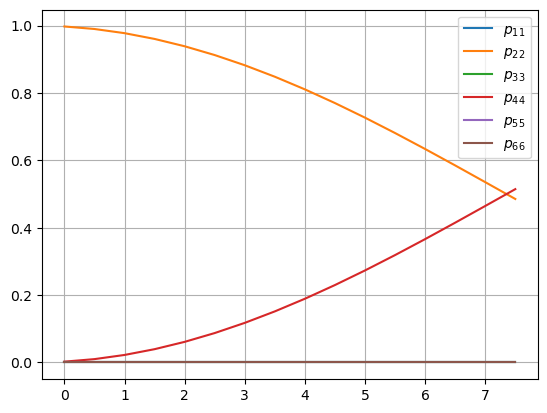

In [37]:
from matplotlib import pyplot as plt
plt.plot(t, rho_1, label="$p_{11}$")
plt.plot(t, rho_2, label="$p_{22}$")
plt.plot(t, rho_3, label="$p_{33}$")
plt.plot(t, rho_4, label="$p_{44}$")
plt.plot(t, rho_5, label="$p_{55}$")
plt.plot(t, rho_6, label="$p_{66}$")
plt.grid()
#plt.xlim(10,20)
plt.legend()
plt.show()

In [53]:
print(np.array2string(rho_new, formatter={'all': complex_formatter}))

[[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.51 -0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.50  0.49  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]


In [14]:
# create initial density matrix
rho_init = np.outer(zeg_ket, zeg_ket.reshape(8,1))
ket_init = zeg_ket

#print(zeg_ket)
E2 = H1[2,2]

res = H1 @ zeg_ket - E2 * zeg_ket
print(res)

[[0. ]
 [0. ]
 [0. ]
 [0. ]
 [0.1]
 [0. ]
 [0. ]
 [0. ]]
